In [14]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar 

--2022-02-16 18:42:07--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  17.5MB/s    in 2.9s    

2022-02-16 18:42:11 (17.5 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [15]:
!pip install navec

In [16]:
!pip install slovnet

In [17]:
import pandas as pd

import numpy as np
import sklearn

In [18]:
from nltk.tokenize import WordPunctTokenizer
from gensim.models import Word2Vec

from navec import Navec

In [19]:
import torch
from slovnet.model.emb import NavecEmbedding

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
def clear_text(text: str):
  bad_symbols = [",", "!", ":", "/", ".", "|", "(", ")", "-", "_", "?",";"]
  clear_text = ''

  for symbol in text:
    if symbol not in bad_symbols:
      clear_text += symbol
  return clear_text

In [22]:
def add_zero_indexes(ind, max_text_ind_len):
    if len(ind) < max_text_ind_len:
        z_arr = np.zeros((max_text_ind_len - len(ind)),dtype=np.int64).T
        ind = np.concatenate((ind,z_arr),axis=0)
    return ind

In [23]:
def bin2classes(x:int):
    return np.array([0,1]) if x == 1 else np.array([1,0])
def classes2bin(x):
    return 0 if x == [1,0] else 1

In [24]:
def get_text_indexes(words: str, word_model):
    indexes = []

    for word in words:
        try:
          indexes.append(word_model.vocab[word])
        except KeyError:
          indexes.append(0)

    return np.array(indexes, dtype=np.int64)

In [25]:
model = Navec.load("navec_hudlit_v1_12B_500K_300d_100q.tar")

In [27]:
train_data = pd.read_csv("labeled.csv")

In [28]:
tokenizer = WordPunctTokenizer()

In [29]:
train_data

,Unnamed: 0,Unnamed: 0.1,comment,toxic
0,0,0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,1,1,"Хохлы, это отдушина затюканного россиянина, мо...",1.0
2,2,2,Собаке - собачья смерть\n,1.0
3,3,3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,4,4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...,...,...
14407,14407,14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,14408,14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,14409,14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,14410,14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [30]:
train_data = train_data.sort_values(by=["comment"], key=lambda x: x.str.len())

In [31]:
train_data["comment"] = train_data["comment"].apply(lambda x: tokenizer.tokenize(x.lower()))

In [32]:
#train_data["toxic"] = train_data["toxic"].apply(lambda x: bin2classes(x))

In [33]:
train_data

,Unnamed: 0,Unnamed: 0.1,comment,toxic
14022,14022,14022,"[разъ, бан, азъ, бан]",1.0
2439,2439,2439,"[ты, чо, дурачок, чтоли]",1.0
1388,1388,1388,"[малыш, (, подвергается, )]",0.0
1268,1268,1268,"[завидуешь, по, -, черному, ?]",0.0
1842,1842,1842,"[но, она, же, красивая, ...]",0.0
...,...,...,...,...
13688,13688,13688,"[агентство, darpa, в, 2020, году, планирует, н...",0.0
1953,1953,1953,"[в, киеве, на, вокpале, мены, було, рок, в, 19...",1.0
5795,5795,5795,"[с, 19, апреля, в, николаеве, будет, действова...",0.0
3016,3016,3016,"[блеадь, ,, как, же, обидно, когда, создаешь, ...",1.0


In [34]:
train_data['indexed_text'] = train_data['comment'].apply(lambda x: get_text_indexes(x,model))

In [35]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,comment,toxic,indexed_text
14022,14022,14022,"[разъ, бан, азъ, бан]",1.0,"[365611, 30833, 17440, 30833]"
2439,2439,2439,"[ты, чо, дурачок, чтоли]",1.0,"[444216, 481798, 118484, 482092]"
1388,1388,1388,"[малыш, (, подвергается, )]",0.0,"[205634, 0, 306288, 0]"
1268,1268,1268,"[завидуешь, по, -, черному, ?]",0.0,"[127234, 302187, 0, 479841, 0]"
1842,1842,1842,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]"


In [36]:
train_data['indexed_text_len'] = train_data['indexed_text'].apply(lambda x: len(x))

In [37]:
train_data

,Unnamed: 0,Unnamed: 0.1,comment,toxic,indexed_text,indexed_text_len
14022,14022,14022,"[разъ, бан, азъ, бан]",1.0,"[365611, 30833, 17440, 30833]",4
2439,2439,2439,"[ты, чо, дурачок, чтоли]",1.0,"[444216, 481798, 118484, 482092]",4
1388,1388,1388,"[малыш, (, подвергается, )]",0.0,"[205634, 0, 306288, 0]",4
1268,1268,1268,"[завидуешь, по, -, черному, ?]",0.0,"[127234, 302187, 0, 479841, 0]",5
1842,1842,1842,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]",5
...,...,...,...,...,...,...
13688,13688,13688,"[агентство, darpa, в, 2020, году, планирует, н...",0.0,"[16206, 3016, 51199, 0, 91885, 300229, 235924,...",712
1953,1953,1953,"[в, киеве, на, вокpале, мены, було, рок, в, 19...",1.0,"[51199, 169208, 225007, 0, 212129, 49031, 3793...",1162
5795,5795,5795,"[с, 19, апреля, в, николаеве, будет, действова...",0.0,"[383451, 0, 24273, 51199, 249193, 48454, 10389...",885
3016,3016,3016,"[блеадь, ,, как, же, обидно, когда, создаешь, ...",1.0,"[0, 0, 161623, 122803, 254781, 173619, 408931,...",970


In [38]:
train_data = train_data.iloc[:-20]

In [39]:
train_data

,Unnamed: 0,Unnamed: 0.1,comment,toxic,indexed_text,indexed_text_len
14022,14022,14022,"[разъ, бан, азъ, бан]",1.0,"[365611, 30833, 17440, 30833]",4
2439,2439,2439,"[ты, чо, дурачок, чтоли]",1.0,"[444216, 481798, 118484, 482092]",4
1388,1388,1388,"[малыш, (, подвергается, )]",0.0,"[205634, 0, 306288, 0]",4
1268,1268,1268,"[завидуешь, по, -, черному, ?]",0.0,"[127234, 302187, 0, 479841, 0]",5
1842,1842,1842,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0]",5
...,...,...,...,...,...,...
303,303,303,"[английские, ученые, из, центра, исследований,...",0.0,"[21875, 459529, 147875, 476225, 158050, 389729...",416
77,77,77,"[число, проституток, в, израиле, продолжает, р...",0.0,"[481291, 351523, 51199, 150835, 346251, 370974...",491
35,35,35,"[возьмём, как, пример, россию, ,, западноевроп...",0.0,"[67022, 161623, 339099, 380170, 0, 135081, 421...",516
14164,14164,14164,"[совместная, российско, -, американская, мисси...",0.0,"[407766, 0, 0, 20927, 216442, 55714, 0, 99732,...",476


In [40]:
max_len = train_data['indexed_text_len'].max()
max_len

526

In [41]:
train_data["indexed_text"] = train_data["indexed_text"].apply(lambda x: add_zero_indexes(x, max_len))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
train_data

,Unnamed: 0,Unnamed: 0.1,comment,toxic,indexed_text,indexed_text_len
14022,14022,14022,"[разъ, бан, азъ, бан]",1.0,"[365611, 30833, 17440, 30833, 0, 0, 0, 0, 0, 0...",4
2439,2439,2439,"[ты, чо, дурачок, чтоли]",1.0,"[444216, 481798, 118484, 482092, 0, 0, 0, 0, 0...",4
1388,1388,1388,"[малыш, (, подвергается, )]",0.0,"[205634, 0, 306288, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
1268,1268,1268,"[завидуешь, по, -, черному, ?]",0.0,"[127234, 302187, 0, 479841, 0, 0, 0, 0, 0, 0, ...",5
1842,1842,1842,"[но, она, же, красивая, ...]",0.0,"[250090, 267314, 122803, 183771, 0, 0, 0, 0, 0...",5
...,...,...,...,...,...,...
303,303,303,"[английские, ученые, из, центра, исследований,...",0.0,"[21875, 459529, 147875, 476225, 158050, 389729...",416
77,77,77,"[число, проституток, в, израиле, продолжает, р...",0.0,"[481291, 351523, 51199, 150835, 346251, 370974...",491
35,35,35,"[возьмём, как, пример, россию, ,, западноевроп...",0.0,"[67022, 161623, 339099, 380170, 0, 135081, 421...",516
14164,14164,14164,"[совместная, российско, -, американская, мисси...",0.0,"[407766, 0, 0, 20927, 216442, 55714, 0, 99732,...",476


In [43]:
X = train_data['indexed_text'].to_list()

In [44]:
y = train_data["toxic"].to_list()

In [45]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.02, random_state=42)

In [46]:
X = []

In [47]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")

In [77]:
class TextClassifierNN(torch.nn.Module):
    """
        Neural network model for the classification of text tonality
    """
    def __init__(self, embedding_dim: int, gru_hidden_size: int, fc_hidden_size: int, output_size: int, navec) -> None:
        """
        :param embedding_dim: embedding dim
        :param gru_hidden_size: gru hidden size
        :param fc_hidden_size: full connected hidden size
        :param output_size: output size
        :param navec: navec model
        """
        super(TextClassifierNN, self).__init__()

        self.relu = torch.nn.ReLU()

        self.softmax = torch.nn.Softmax(dim=1)

        self.embedding = NavecEmbedding(navec)  # torch.nn.Embedding(input_size, embedding_dim)

        #weights = torch.FloatTensor(model.vectors)
        #self.embedding = torch.nn.Embedding.from_pretrained(weights)

        self.conv1 = torch.nn.Conv1d(embedding_dim, 512, kernel_size=(5,), padding=2)
        self.conv2 = torch.nn.Conv1d(512, 1024, kernel_size=(3,), padding=1)
        self.conv3 = torch.nn.Conv1d(1024, 2048, kernel_size=(5,), padding=2)

        self.gru = torch.nn.GRU(2048, gru_hidden_size, batch_first=True)

        self.fc1 = torch.nn.Linear(gru_hidden_size, fc_hidden_size)

        self.fc2 = torch.nn.Linear(fc_hidden_size, output_size)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.embedding(x)

        x = x.permute((0, 2, 1))

        x = self.conv1(x)

        x = self.relu(x)

        x = self.conv2(x)

        x = self.relu(x)

        x = self.conv3(x)

        x = self.relu(x)

        x = x.permute((0, 2, 1))

        x = self.gru(x)[0].mean(dim=1)  # (batch_size, L, hidden_size)

        x = self.fc1(x)

        x = self.relu(x)

        x = self.fc2(x)

        return x

    def predict(self, x: torch.tensor) -> torch.tensor:
        return self.softmax(self.forward(x))

In [78]:
Net = TextClassifierNN(300, 512, 256, 2, model)
Net.to(device)

loss = torch.nn.CrossEntropyLoss()

In [79]:
optimizer = torch.optim.Adam(Net.parameters(), lr=1.0e-3)

In [80]:
test_loss_history = []
test_accuracy_history = []
test_precision_history = []

In [81]:
X_train = torch.LongTensor(X_train)
y_train = torch.LongTensor(y_train)

X_test = torch.LongTensor(X_test)
y_test = torch.LongTensor(y_test)

In [82]:
Net.train()

batch_size = 256

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        with torch.no_grad():
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]#.to(device)
            y_batch = y_train[batch_indexes]#.to(device)
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

        preds = Net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    with torch.no_grad():
      test_preds = Net.forward(X_test.cuda()).cpu()

      loss_test_value = loss(test_preds, y_test).detach().data.cpu()


      test_loss_history.append(loss_test_value)
      
      accuracy = (test_preds.argmax(dim=1) == y_test).detach().float().mean().data.cpu()
      test_accuracy_history.append(accuracy)
      
      precision = sklearn.metrics.precision_score(test_preds.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
      test_precision_history.append(precision)

      print(f"epoch {epoch+1}; test loss {loss_test_value}; test accuracy {accuracy}; test precision {precision}")
torch.save(Net.state_dict(),"TextTonalityClassifier.nn")

epoch 1; test loss 0.3427463173866272; test accuracy 0.8472222089767456; test precision 0.6222222222222222
epoch 2; test loss 0.331574410200119; test accuracy 0.8368055820465088; test precision 0.8
epoch 3; test loss 0.3114681839942932; test accuracy 0.875; test precision 0.8111111111111111
epoch 4; test loss 0.3379800617694855; test accuracy 0.8645833134651184; test precision 0.8777777777777778
epoch 5; test loss 0.3932482898235321; test accuracy 0.8854166865348816; test precision 0.7444444444444445


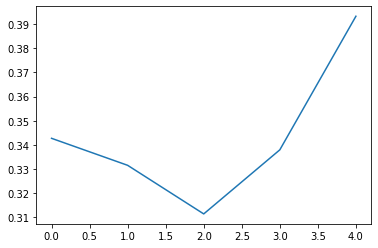

In [83]:
plt.plot(test_loss_history, label='loss')

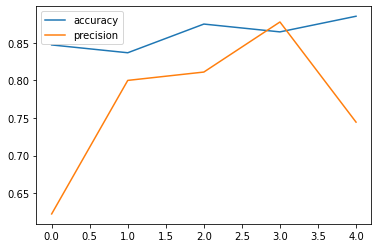

In [84]:
plt.plot(test_accuracy_history, label='accuracy')
plt.plot(test_precision_history, label='precision')
plt.legend()
plt.show()  

In [85]:
with torch.no_grad():
    y_pred = Net.forward(X_test)

In [86]:
precision = sklearn.metrics.precision_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
precision

0.7444444444444445

In [87]:
recall = sklearn.metrics.recall_score(y_pred.argmax(dim=1).detach().cpu().numpy(), y_test.detach().cpu().numpy())
recall

0.8701298701298701

In [88]:
!nvidia-smi

Wed Feb 16 20:07:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    36W /  70W |  14574MiB / 15109MiB |     90%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [61]:
torch.save(Net.state_dict(),"TextTonalityClassifier.nn")